## Supervised Learning Potpourri
# 2 - Airline Arrivals
### Sam Fradkin

Use [this dataset](http://stat-computing.org/dataexpo/2009/the-data.html) of airline arrival information to predict how late flights will be. A flight only counts as late if it is more than 30 minutes late.

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from xgboost                   import XGBRegressor
from sklearn                   import ensemble
from sklearn.utils             import resample
from sklearn.metrics           import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble          import RandomForestRegressor
from sklearn.model_selection   import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest

import warnings
warnings.filterwarnings('ignore')

# 1) Dataset Overview

Let's take a look at the dataset provided.

In [19]:
df = pd.read_csv('Airline Arrivals 2008.csv')

In [3]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [4]:
df.shape

(7009728, 29)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
FlightNum            int64
TailNum              object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
TaxiIn               float64
TaxiOut              float64
Cancelled            int64
CancellationCode     object
Diverted             int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtypes: float64(14), int64(10), object(5)
memory usage: 1.5+ GB


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,7009728.0,2008.000000,0.000000,2008.0,2008.0,2008.0,2008.0,2008.0
Month,7009728.0,6.375130,3.406737,1.0,3.0,6.0,9.0,12.0
DayofMonth,7009728.0,15.728015,8.797068,1.0,8.0,16.0,23.0,31.0
DayOfWeek,7009728.0,3.924182,1.988259,1.0,2.0,4.0,6.0,7.0
DepTime,6873482.0,1333.830046,478.068895,1.0,928.0,1325.0,1728.0,2400.0
CRSDepTime,7009728.0,1326.085663,464.250911,0.0,925.0,1320.0,1715.0,2359.0
ArrTime,6858079.0,1481.258227,505.225129,1.0,1107.0,1512.0,1909.0,2400.0
CRSArrTime,7009728.0,1494.801154,482.672822,0.0,1115.0,1517.0,1907.0,2400.0
FlightNum,7009728.0,2224.200105,1961.715999,1.0,622.0,1571.0,3518.0,9743.0
ActualElapsedTime,6855029.0,127.322424,70.187308,12.0,77.0,110.0,157.0,1379.0


# 2) Data Cleaning

Let's start cleaning up our dataset. We will focus on two aspects of the data:<br>

__1)__ Some of our data is not in usable type formats as well as other similar dirty-data issues.<br>
__2)__ Our dataset is ridiculously large. We need to trim it down without losing any informational integrity to enable our models to run without being computationally expensive.

First let's start by removing all unnecessary rows and columns that will not detract from the integrity of our dataset.

In [20]:
# Remove all flights that were cancelled as they have no value in predicting delay times
df = df[df['Cancelled'] == 0]

In [21]:
# Remove all columns that add no value to delay predictions
df.drop(['Year', 'FlightNum', 'Cancelled', 'CancellationCode', 'TailNum', 'ActualElapsedTime', 'Diverted'], 1, inplace=True)

In [22]:
# From the DESCRIBE print, it appears that the last five features are missing about 80% of their data.
# Let's remove those features too.
df.drop(['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], 1, inplace=True)

Here we'll add a new boolean feature indicating if a flight is considered "Delayed" or not based on the guidelines provided in the challenge:<br> __Arrival Delay > 30 minutes = "Delayed"__

In [23]:
# Let's create a new boolean feature that indicates if a flight was delayed (>30 minutes late).
df['Delayed'] = np.where(df['ArrDelay'] > 30, 1, 0)

How many rows in our dataset are populated with NaN values? If it is a relatively large amount, we will not be able to simply remove them and we will be forced to find another method of dealing with those rows. If these rows are a small enough ratio of the set, we can just remove them.

In [25]:
# How many NaN rows do we have?
shapebefore = df.shape[0]
shapeafter  = df.dropna().shape[0]
shapedif    = shapebefore - shapeafter
shapedifpct = round((shapedif / shapebefore) * 100, 3)
print('Our dataset has', shapebefore, 'rows, of which', shapedif, 'contain NaN values, which makes up', 
      shapedifpct, 'percent of the dataset.')

Our dataset has 6872294 rows, of which 17265 contain NaN values, which makes up 0.251 percent of the dataset.


Looks like we can afford to drop those rows without losing any data integrity. Let's do it.

In [26]:
# Looks like we can afford to drop those rows without losing any data integrity. Let's do it.
df.dropna(inplace = True)

Now let's convert the column types into datatypes that are less computationally-expensive.

In [27]:
# Convert the columns to less computationally-expensive data types
flt2int = ['CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'TaxiIn', 'TaxiOut']
flt2flt = ['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime']
int2int = ['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'Delayed']

for i in flt2int:
    df[i] = df[i].astype(np.int16)

for i in flt2flt:
    df[i] = df[i].astype(np.float16)

for i in int2int:
    df[i] = df[i].astype(np.int16)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6855029 entries, 0 to 7009727
Data columns (total 18 columns):
Month             int16
DayofMonth        int16
DayOfWeek         int16
DepTime           float16
CRSDepTime        float16
ArrTime           float16
CRSArrTime        float16
UniqueCarrier     object
CRSElapsedTime    int16
AirTime           int16
ArrDelay          int16
DepDelay          int16
Origin            object
Dest              object
Distance          int16
TaxiIn            int16
TaxiOut           int16
Delayed           int16
dtypes: float16(4), int16(11), object(3)
memory usage: 405.3+ MB


Wow! Our memory usage dropped by over a GB!<br><br>

Taking a closer look at the data, it appears that the time values that are provided as integers and floats are actually clock times, and therefore cannot use basic arithmetic calculations. We must convert the data to types that can be tabulated accurately.

In [28]:
# Convert all relevant columns into arithmetic-ready number types
df['DepTime'   ] = df['DepTime'   ].apply(lambda x: round(np.floor_divide(x, 100) + (np.remainder(x, 100) / 60), 2))
df['CRSDepTime'] = df['CRSDepTime'].apply(lambda x: round(np.floor_divide(x, 100) + (np.remainder(x, 100) / 60), 2))
df['ArrTime'   ] = df['ArrTime'   ].apply(lambda x: round(np.floor_divide(x, 100) + (np.remainder(x, 100) / 60), 2))
df['CRSArrTime'] = df['CRSArrTime'].apply(lambda x: round(np.floor_divide(x, 100) + (np.remainder(x, 100) / 60), 2))

In [13]:
# Let's see what our data looks like now.
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Delayed
0,1,3,4,20.05,19.92,22.20,22.40,WN,150,116,-14,8,IAD,TPA,810,4,8,0
1,1,3,4,7.90,7.58,10.03,10.00,WN,145,113,2,19,IAD,TPA,810,5,10,0
2,1,3,4,6.47,6.33,8.07,7.83,WN,90,76,14,8,IND,BWI,515,3,17,0
3,1,3,4,9.43,9.50,10.90,11.00,WN,90,78,-6,-4,IND,BWI,515,3,7,0
4,1,3,4,18.48,17.92,19.98,19.42,WN,90,77,34,34,IND,BWI,515,3,10,1


# 3) Data Analysis
Let's find out the flight status distribution of On-Time vs. Delayed flights in our dataset

In [14]:
# Calculate the distribution of On-Time vs. Delayed flights
totalflights = len(df.Delayed)
delayed    = df['Delayed'].value_counts()[1]
ontime     = df['Delayed'].value_counts()[0]
delayedpct = delayed / totalflights
ontimepct  = ontime  / totalflights

print('--- Flight Status Counts ---')
print()
print('Total Flights: ', str(totalflights))
print('On Time:       ', str(ontime),   '  (', str(round((ontimepct  * 100), 2)), '%)')
print('Delayed:        ', str(delayed), '  (', str(round((delayedpct * 100), 2)), '%)')

--- Flight Status Counts ---

Total Flights:  6855029
On Time:        5953631   ( 86.85 %)
Delayed:         901398   ( 13.15 %)


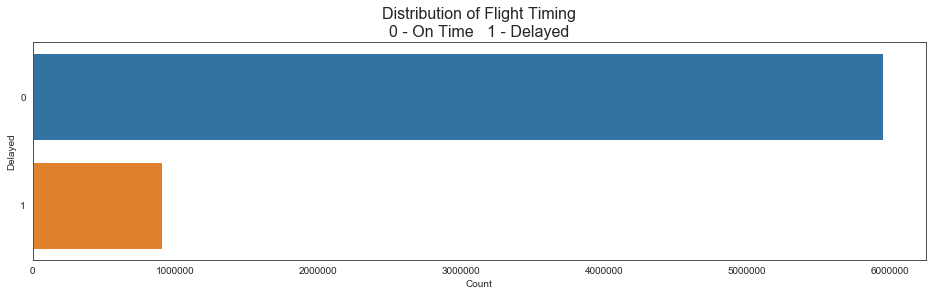

In [19]:
plt.figure(figsize=(16, 4))
sns.countplot(y = 'Delayed', data = df)
plt.xlabel('Count')
plt.title('Distribution of Flight Timing\n0 - On Time   1 - Delayed', fontsize = 16)
plt.show()

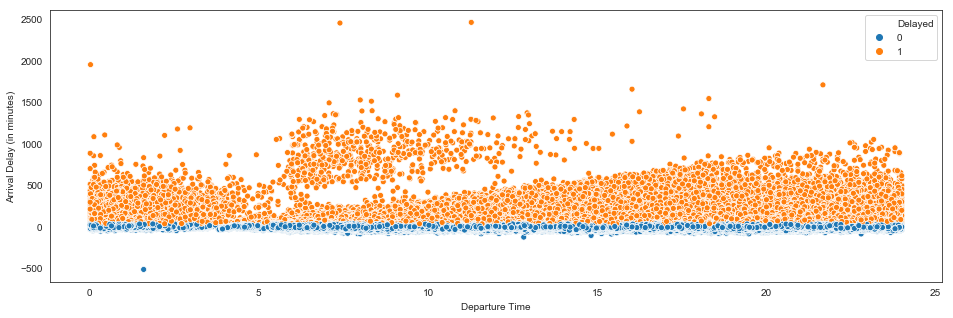

In [21]:
plt.figure(figsize=(16,5))
sns.scatterplot(x = 'DepTime', y = 'ArrDelay', hue = 'Delayed', data = df)
plt.xlabel('Departure Time')
plt.ylabel('Arrival Delay (in minutes)')
plt.show()

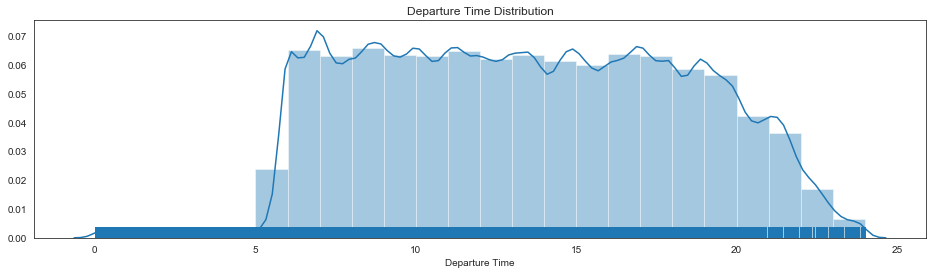

In [23]:
departurecolumn = df['DepTime']

plt.figure(figsize=(16,4))
sns.distplot(departurecolumn, bins = 24, rug = True)
plt.title('Departure Time Distribution')
plt.xlabel('Departure Time')
plt.show()

In [15]:
# Create a table of all the UniqueCarrier airlines in the dataset and count how many flights they have
airlines = df['UniqueCarrier'].value_counts()
airlines = pd.DataFrame(airlines)

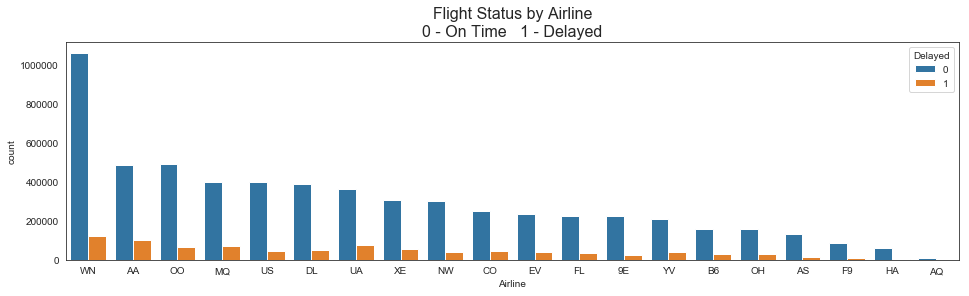

In [25]:
# Create a countplot showing each airline and their ratio of On-Time vs. Delayed flights
plt.figure(figsize=(16,4))
sns.countplot(x = 'UniqueCarrier', hue = 'Delayed', data = df, order = airlines.index)
plt.title('Flight Status by Airline\n0 - On Time   1 - Delayed', fontsize = 16)
plt.xlabel('Airline')
plt.show()

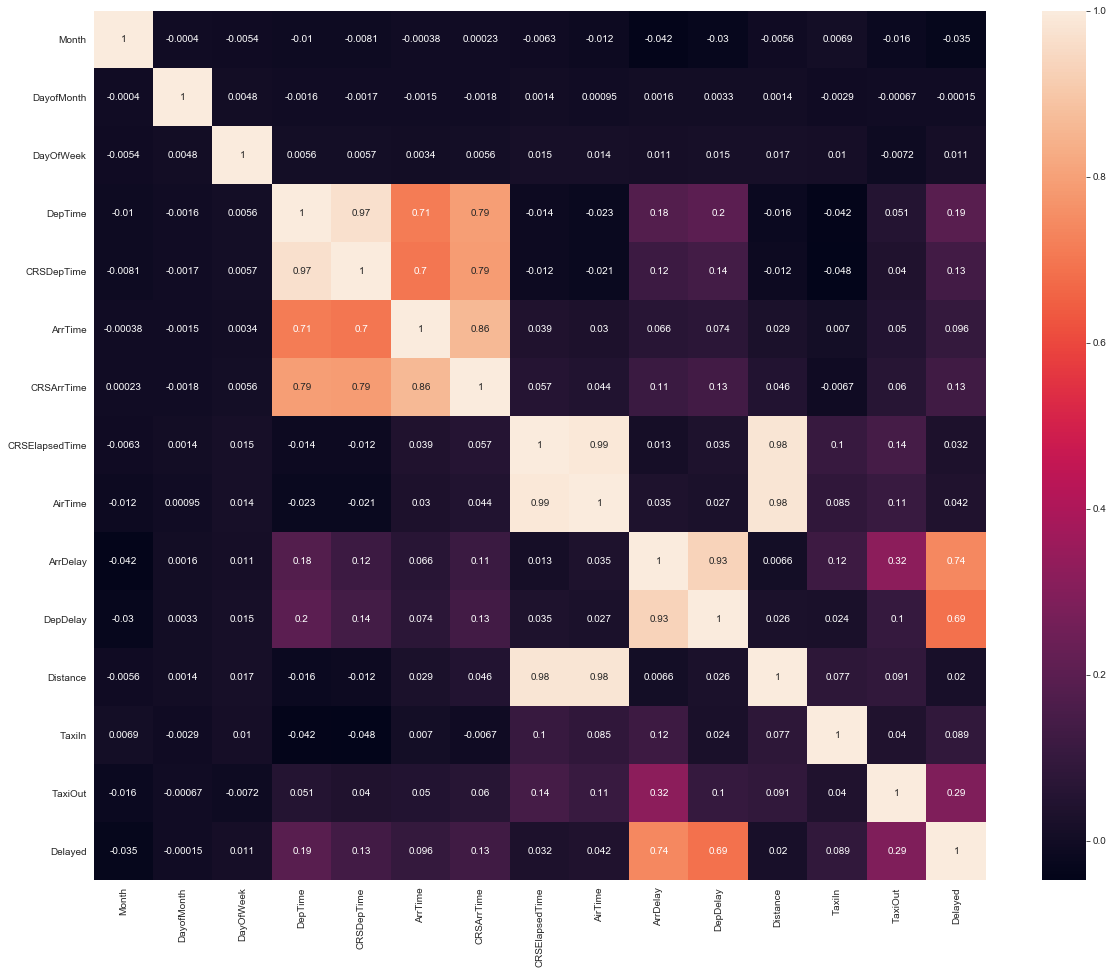

In [26]:
# Create a heatmap of feature correlations
plt.figure(figsize=(20,16))
sns.heatmap(df.corr(), annot=True)
plt.show()

# 4) Modeling
## 4A) Random Forest

We saw earlier that our dataset's ratio of 'Delayed' datapoints is heavily weighted towards the non-delayed side. If we want to have an accurate Random Forest, we need to equalize our sample that we will be using.
Let's downsample the non-delayed sample to the amount equal to that of the 'Delayed' sample and then run our model.

In [29]:
# Seperate the Delayed from the On-Time into two datasets
df_delayed = df[df.Delayed == 1]
df_ontime  = df[df.Delayed == 0]

# Downsample the On-Time dataset to match the number of rows in te Delayed dataset
df_ot_downsample = resample(df_ontime, replace = True, n_samples = df_delayed.shape[0], random_state = 101)

# Combine both datasets into one
combined_delay_sample = pd.concat([df_delayed, df_ot_downsample])

# Let's see if the new combined dataset has equal values for both Delayed and On-Time
print('New Combined Downsampled Dataset\nDELAYED Value Counts')
combined_delay_sample['Delayed'].value_counts()

New Combined Downsampled Dataset
DELAYED Value Counts


1    901398
0    901398
Name: Delayed, dtype: int64

In [30]:
# Let's split the data into a train set and test set
X = combined_delay_sample.drop(['ArrDelay', 'UniqueCarrier', 'Origin', 'Dest'], 1)
y = combined_delay_sample['ArrDelay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [31]:
rfr = RandomForestRegressor(n_estimators = 100)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

It took 30 minutes to fit the data. Let's see how long it takes to run the actual regression model.

In [32]:
predictions = rfr.predict(X_test)
rfrrsq = round(rfr.score(X_test, y_test) * 100, 2)
cvs    = cross_val_score(rfr, X_train, y_train, cv = 5)
print('--- RANDOM FOREST RESULTS ---')
print('R-Squared: ', str(rfrrsq), '%')
print('Cross-Validation Results:')
print(cvs)

--- RANDOM FOREST RESULTS ---
R-Squared:  99.38 %
Cross-Validation Results:
[0.99352757 0.99343883 0.99272099 0.99387209 0.99331513]


It ended up taking 2.5 hours to run.<br><br>
It actually performed pretty well too! Great accuracy and very consistent cross-validation results!<br><br>
Now let's see try XGBoost.

## 4B) XGBoost

Let's see how XGBoost performs on this dataset. Should take a while.

In [37]:
# Split the data into the target variable and the rest. Remove all categorical features.
X = df.drop(['ArrDelay', 'UniqueCarrier', 'Origin', 'Dest'], 1)
y = df['ArrDelay']

# Split the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [38]:
xgb = XGBRegressor(max_depth = 2, learning_rate = 0.1, n_estimators = 500, colsample_bylevel = 0.4)
xgb.fit(X_train, y_train)

[11:05:49] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.4,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [39]:
predictions = xgb.predict(X_test)
xgbrsq = round(xgb.score(X_test, y_test) * 100, 2)
cvs    = cross_val_score(xgb, X_train, y_train, cv = 5)

--- XGBOOST RESULTS ---
R-Squared:  99.38 %
Cross-Validation Results:
[0.96916964 0.96901959 0.96920271 0.96942464 0.96889602]


In [40]:
print('--- XGBOOST RESULTS ---')
print('R-Squared: ', str(xgbrsq), '%')
print('Cross-Validation Results:')
print(cvs)

--- XGBOOST RESULTS ---
R-Squared:  88.93 %
Cross-Validation Results:
[0.96916964 0.96901959 0.96920271 0.96942464 0.96889602]


In [42]:
cvs_min = cvs.min()
cvs_max = cvs.max()
cvs_range = cvs_max - cvs_min
print('Cross-Validation Range')
print(cvs_range)

Cross-Validation Range
0.0005286219590674435


It took 2 hours to fit the data and another few hours to run the XGBoost model. The results were alright but not as good as I thought it would be.

# 5) Summary
It turns out that the balanced dataset that went through the Random Forest model scored much higher accuracy levels than the XGBoost model. I had thought that the reverse would have occurred.<br><br>

__---Random Forest---__<br>
R-Squared:              99.38%<br>
Cross-Validation Range: 0.00115511
<br><br>
__------XGBoost------__<br>
R-Squared:              88.93%<br>
Cross-Validation Range: 0.00052862